In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import sys

print("✓ Librerie importate")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponibile: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✓ Librerie importate
PyTorch version: 2.7.1+cu118
Device disponibile: cuda


## 2. DATA LOADING

In [2]:
# Leggi il file Parquet OVEN
Oven = pd.read_parquet("datasets_by_subject/Warmtepomp-Sturing.parquet")
Oven['_time'] = pd.to_datetime(Oven['_time'])
Oven = Oven.sort_values('_time').reset_index(drop=True)
print(f"Oven caricato: {Oven.shape[0]} righe, {Oven.shape[1]} colonne")
Oven.head()

Oven caricato: 35037 righe, 12 colonne


,_time,_measurement,_field,_value,building,device_ID,msr_ID,msr_category,msr_device,msr_extra,msr_spec,msr_subject
0,2024-10-20 02:15:00,Electricity,kW,-0.007910,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
1,2024-10-20 02:30:00,Electricity,kW,-0.007956,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
2,2024-10-20 02:45:00,Electricity,kW,-0.007950,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
3,2024-10-20 03:00:00,Electricity,kW,-0.007968,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
4,2024-10-20 03:15:00,Electricity,kW,-0.007880,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing


In [3]:
# Carica BUILDING (estrae dal dataset principale se necessario)
building_path = "datasets_by_subject/Building.parquet"

if not os.path.exists(building_path):
    print("Estraggo Building dal dataset principale...")
    df_main = pd.read_parquet("influxdb_query_20251020_074134.parquet")
    Building = df_main[df_main['msr_subject'] == 'Building'].copy()
    Building = Building.sort_values('_time').reset_index(drop=True)
    Building.to_parquet(building_path, compression='snappy', engine='fastparquet')
    print(f"✓ Building salvato in {building_path}")
else:
    Building = pd.read_parquet(building_path)
    Building['_time'] = pd.to_datetime(Building['_time'])

print(f"Building caricato: {Building.shape[0]} righe, {Building.shape[1]} colonne")
Building.head()

Building caricato: 140148 righe, 12 colonne


,_time,_measurement,_field,_value,building,device_ID,msr_ID,msr_category,msr_device,msr_extra,msr_spec,msr_subject
index,,,,,,,,,,,,
420440,2024-10-20 02:15:00,Electricity,kW,0.198563,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420441,2024-10-20 02:30:00,Electricity,kW,0.228958,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420442,2024-10-20 02:45:00,Electricity,kW,0.216411,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420443,2024-10-20 03:00:00,Electricity,kW,0.170043,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420444,2024-10-20 03:15:00,Electricity,kW,0.180233,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building


## 3. EXPLORATORY DATA ANALYSIS

In [4]:
# Analizza OVEN
time_diff = Oven['_time'].diff()
total_duration = Oven['_time'].max() - Oven['_time'].min()

print("=== OVEN ===")
print(f"Intervallo minimo: {time_diff.min()}")
print(f"Intervallo massimo: {time_diff.max()}")
print(f"Intervallo medio: {time_diff.mean()}")
print(f"Durata totale: {total_duration.days} giorni")
print(f"Righe per giorno: {len(Oven) / total_duration.days:.0f}")

# Calcola sequenze per 1 giorno
rows_for_1_day = int((len(Oven) / total_duration.days) * 1)
print(f"Righe per 1 giorno: {rows_for_1_day}")

=== OVEN ===
Intervallo minimo: 0 days 00:00:00
Intervallo massimo: 0 days 01:15:00
Intervallo medio: 0 days 00:15:00.077063591
Durata totale: 364 giorni
Righe per giorno: 96
Righe per 1 giorno: 96


In [5]:
# Analizza BUILDING
time_diff_building = Building['_time'].diff()
total_duration_building = Building['_time'].max() - Building['_time'].min()

print("=== BUILDING ===")
print(f"Intervallo minimo: {time_diff_building.min()}")
print(f"Intervallo massimo: {time_diff_building.max()}")
print(f"Intervallo medio: {time_diff_building.mean()}")
print(f"Durata totale: {total_duration_building.days} giorni")
print(f"Righe per giorno: {len(Building) / total_duration_building.days:.0f}")

rows_for_1_day_building = int((len(Building) / total_duration_building.days) * 1)
print(f"Righe per 1 giorno: {rows_for_1_day_building}")

# Usa il minimo
window_size = min(rows_for_1_day, rows_for_1_day_building)
print(f"\nWindow size scelto: {window_size} (sequenza di ~1 giorno)")

=== BUILDING ===
Intervallo minimo: -365 days +00:15:00
Intervallo massimo: 0 days 01:15:00
Intervallo medio: 0 days 00:03:45.014449114
Durata totale: 364 giorni
Righe per giorno: 385
Righe per 1 giorno: 385

Window size scelto: 96 (sequenza di ~1 giorno)


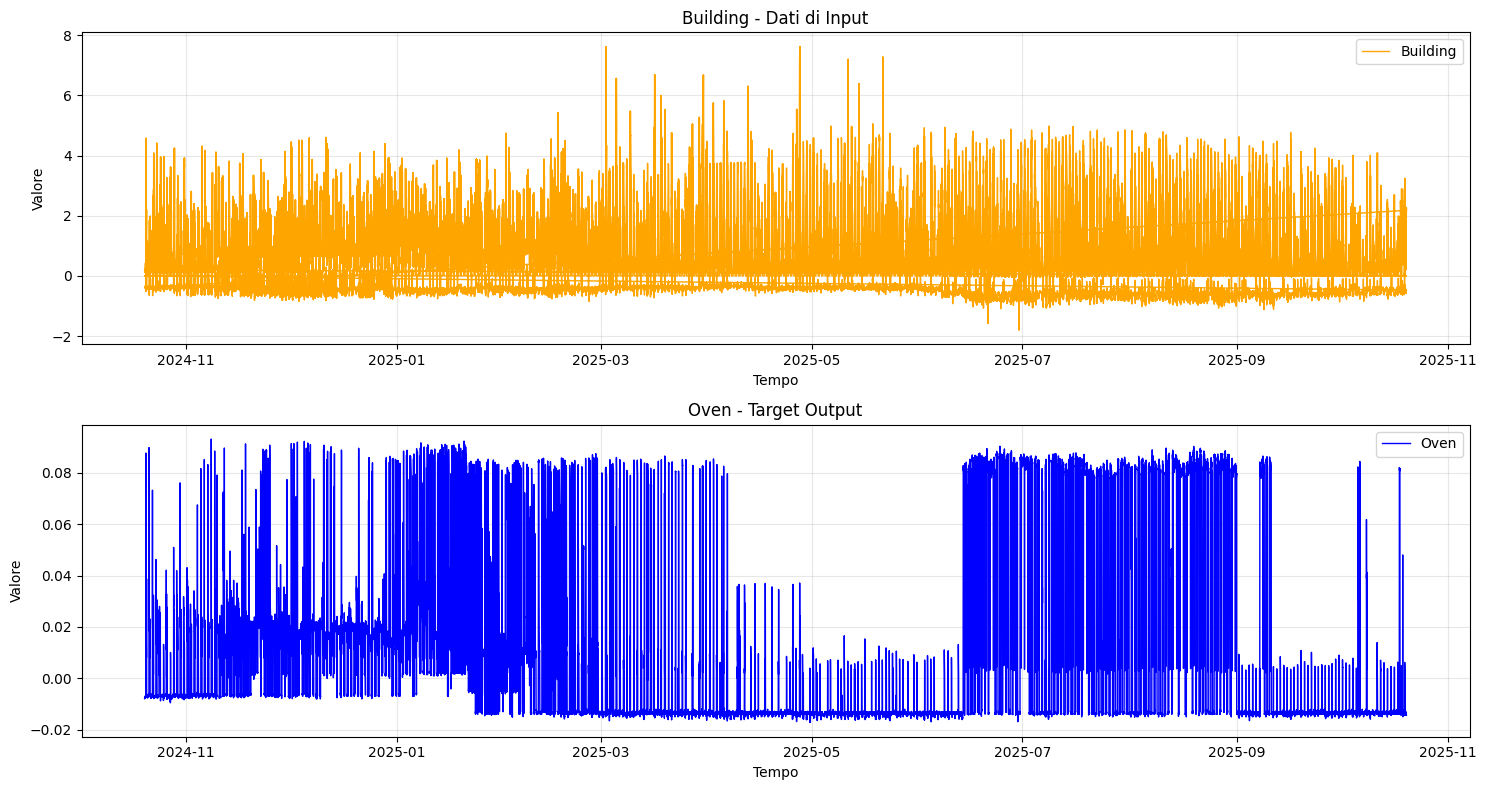

In [6]:
# Visualizza le timeline complete
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(Building['_time'], Building['_value'], linewidth=1, color='orange', label='Building')
axes[0].set_title('Building - Dati di Input')
axes[0].set_xlabel('Tempo')
axes[0].set_ylabel('Valore')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(Oven['_time'], Oven['_value'], linewidth=1, color='blue', label='Oven')
axes[1].set_title('Oven - Target Output')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Valore')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. SEQUENCE CREATION

In [7]:
def create_lstm_sequences(df, seq_length, target_col='_value', pad_mode='edge'):
    """
    Crea sequenze LSTM dal dataframe
    """
    sequences = []
    labels = []

    for index in range(len(df)):
        start_idx = index
        end_idx = index + seq_length

        if end_idx > len(df):
            break

        seq = df.iloc[start_idx:end_idx].copy()
        label = df.iloc[end_idx - 1][target_col]

        # Padding se necessario
        if len(seq) < seq_length:
            pad_width = seq_length - len(seq)
            if pad_mode == 'edge':
                pad_df = pd.concat([seq.iloc[[0]]] * pad_width, ignore_index=True)
            else:
                pad_df = pd.DataFrame(np.zeros((pad_width, seq.shape[1])), columns=seq.columns)
            seq = pd.concat([pad_df, seq], ignore_index=True)

        sequences.append(seq)
        labels.append(label)

    return sequences, pd.Series(labels, name=target_col)

print("✓ Funzione create_lstm_sequences definita")

✓ Funzione create_lstm_sequences definita


In [8]:
# Crea le sequenze
print(f"Creazione sequenze con window_size={window_size}...")
seq_building, _ = create_lstm_sequences(Building, seq_length=window_size, target_col='_value')
seq_oven, _ = create_lstm_sequences(Oven, seq_length=window_size, target_col='_value')

print(f"Sequenze Building create: {len(seq_building)}")
print(f"Sequenze Oven create: {len(seq_oven)}")

# Allinea il numero di sequenze (prendi il minimo)
min_sequences = min(len(seq_building), len(seq_oven))
seq_building = seq_building[:min_sequences]
seq_oven = seq_oven[:min_sequences]

print(f"\n✓ Sequenze Building: {len(seq_building)}")
print(f"✓ Sequenze Oven: {len(seq_oven)}")
print(f"✓ Dimensione sequenza: {seq_building[0].shape}")

Creazione sequenze con window_size=96...
Sequenze Building create: 140053
Sequenze Oven create: 34942

✓ Sequenze Building: 34942
✓ Sequenze Oven: 34942
✓ Dimensione sequenza: (96, 12)


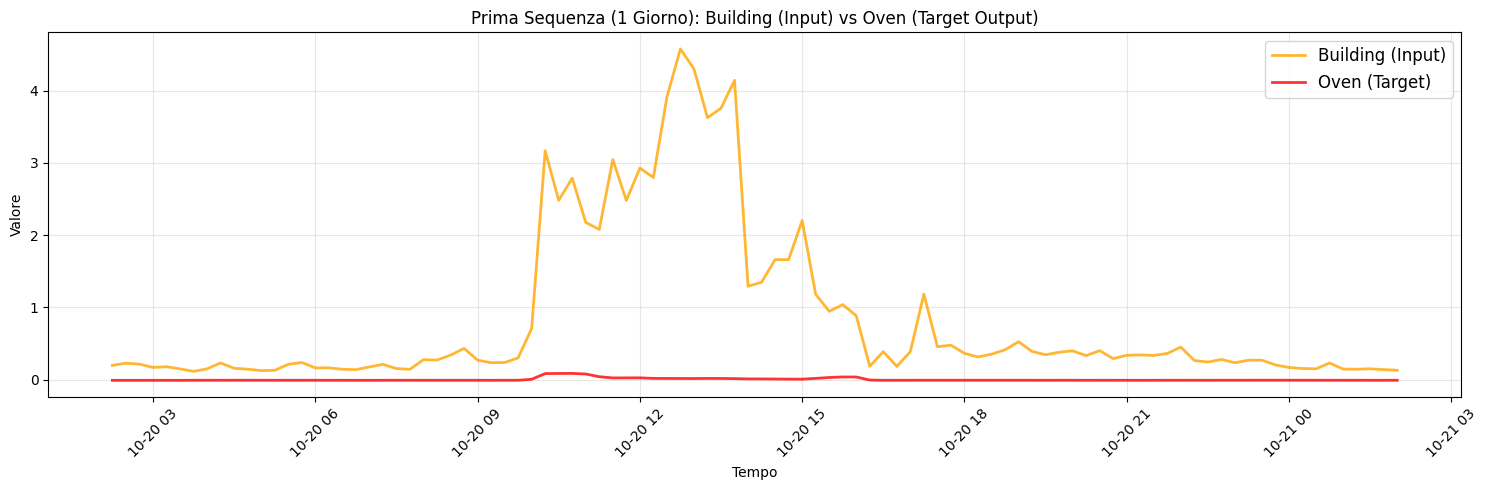

In [9]:
# Visualizza il confronto della prima sequenza
plt.figure(figsize=(15, 5))
plt.plot(seq_building[0]['_time'], seq_building[0]['_value'], linewidth=2, color='orange', label='Building (Input)', alpha=0.8)
plt.plot(seq_oven[0]['_time'], seq_oven[0]['_value'], linewidth=2, color='red', label='Oven (Target)', alpha=0.8)
plt.xlabel('Tempo')
plt.ylabel('Valore')
plt.title('Prima Sequenza (1 Giorno): Building (Input) vs Oven (Target Output)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. MODEL DEFINITION - LSTM Seq2Seq

In [10]:
class LSTMEncoder(nn.Module):
    """Encoder LSTM per Seq2Seq"""
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
    def forward(self, x):
        # x: (batch, seq_len, input_size)
        outputs, (hidden, cell) = self.lstm(x)
        # outputs: (batch, seq_len, hidden_size)
        # hidden, cell: (num_layers, batch, hidden_size)
        return outputs, hidden, cell


class LSTMDecoder(nn.Module):
    """Decoder LSTM per Seq2Seq"""
    def __init__(self, output_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(
            input_size=output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden, cell):
        # x: (batch, 1, output_size) - single step
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        # output: (batch, 1, hidden_size)
        prediction = self.fc(output)
        # prediction: (batch, 1, output_size)
        return prediction, hidden, cell


class LSTMSeq2Seq(nn.Module):
    """Modello LSTM Seq2Seq con Teacher Forcing"""
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMSeq2Seq, self).__init__()
        self.encoder = LSTMEncoder(input_size, hidden_size, num_layers, dropout)
        self.decoder = LSTMDecoder(input_size, hidden_size, num_layers, dropout)
        
    def forward(self, source, target=None, teacher_forcing_ratio=0.5):
        batch_size = source.size(0)
        seq_len = source.size(1)
        output_size = source.size(2)
        
        # Encode
        encoder_outputs, hidden, cell = self.encoder(source)
        
        # Prepare decoder input (start token = primo valore o zero)
        decoder_input = source[:, 0:1, :]  # (batch, 1, output_size)
        
        # Store outputs
        outputs = torch.zeros(batch_size, seq_len, output_size).to(source.device)
        
        # Decode step by step
        for t in range(seq_len):
            prediction, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[:, t:t+1, :] = prediction
            
            # Teacher forcing
            if target is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = target[:, t:t+1, :]
            else:
                decoder_input = prediction
        
        return outputs


print("✓ Modello LSTM Seq2Seq definito")
print("  - Encoder-Decoder architecture")
print("  - Supporta Teacher Forcing")

✓ Modello LSTM Seq2Seq definito
  - Encoder-Decoder architecture
  - Supporta Teacher Forcing


## 6. DATA PREPARATION FOR TRAINING

In [11]:
class EnergyDataset(Dataset):
    def __init__(self, input_sequences, target_sequences):
        self.input_sequences = input_sequences
        self.target_sequences = target_sequences
    
    def __len__(self):
        return len(self.input_sequences)
    
    def __getitem__(self, idx):
        input_seq = torch.FloatTensor(self.input_sequences[idx][['_value']].values)
        target_seq = torch.FloatTensor(self.target_sequences[idx][['_value']].values)
        return input_seq, target_seq

print("✓ EnergyDataset definito")

✓ EnergyDataset definito


## 7. TRAINING

In [12]:
# ===== CONFIGURAZIONE LSTM =====

batch_size = 64           # Batch più piccoli per LSTM (usa più memoria)
sequence_step = 3         # Campionamento sequenze
hidden_size = 128         # Dimensione hidden state LSTM
num_layers = 3            # Layer LSTM
dropout = 0.2             # Dropout
num_epochs = 100          # Epoche
learning_rate = 0.001     # Learning rate
teacher_forcing_ratio = 0.5  # Teacher forcing ratio

# Applica lo step alle sequenze
seq_building_sampled = seq_building[::sequence_step]
seq_oven_sampled = seq_oven[::sequence_step]

# Crea dataset e dataloader
train_dataset = EnergyDataset(seq_building_sampled, seq_oven_sampled)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

num_sequences = len(seq_building_sampled)
num_batches = len(train_loader)

print("=" * 60)
print("CONFIGURAZIONE LSTM Seq2Seq")
print("=" * 60)
print(f"Sequenze: {num_sequences:,} (step={sequence_step})")
print(f"Batch size: {batch_size} | Batches/epoca: {num_batches}")
print(f"Modello: LSTM con {num_layers} layer, hidden_size={hidden_size}")
print(f"Teacher Forcing Ratio: {teacher_forcing_ratio}")
print(f"Device: {'GPU 🚀' if torch.cuda.is_available() else 'CPU'}")
print("=" * 60)

# Setup device e modello LSTM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(
    input_size=1,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n✓ Modello LSTM: {total_params:,} parametri")

# Loss function
class StrictZeroWeightedMSELoss(nn.Module):
    def __init__(self, zero_threshold=0.01, penalty_factor=50.0):
        super(StrictZeroWeightedMSELoss, self).__init__()
        self.zero_threshold = zero_threshold
        self.penalty_factor = penalty_factor
    
    def forward(self, predictions, targets):
        squared_error = (predictions - targets) ** 2
        
        should_be_zero = torch.abs(targets) < self.zero_threshold
        pred_not_zero = torch.abs(predictions) >= self.zero_threshold
        
        weights = torch.ones_like(targets)
        penalty_mask = should_be_zero & pred_not_zero
        weights[penalty_mask] = self.penalty_factor
        
        normal_mask = ~should_be_zero
        if normal_mask.sum() > 0:
            normal_targets = torch.abs(targets[normal_mask])
            normal_weights = normal_targets / (normal_targets.max() + 1e-8)
            normal_weights = 1.0 + normal_weights * 3.0
            weights[normal_mask] = normal_weights
        
        return (squared_error * weights).mean()

criterion = StrictZeroWeightedMSELoss(zero_threshold=0.01, penalty_factor=50.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("✓ Loss e optimizer configurati")

CONFIGURAZIONE LSTM Seq2Seq
Sequenze: 11,648 (step=3)
Batch size: 64 | Batches/epoca: 182
Modello: LSTM con 3 layer, hidden_size=128
Teacher Forcing Ratio: 0.5
Device: GPU 🚀

✓ Modello LSTM: 662,657 parametri
✓ Loss e optimizer configurati


In [13]:
import time

def train_epoch(model, iterator, optimizer, criterion, device, teacher_forcing_ratio):
    model.train()
    epoch_loss = 0
    start_time = time.time()
    
    for input_seq, target_seq in iterator:
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        
        output = model(input_seq, target_seq, teacher_forcing_ratio)
        loss = criterion(output, target_seq)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    elapsed = time.time() - start_time
    return epoch_loss / len(iterator), elapsed

# Training
train_losses = []
print(f"\n🚀 Inizio training LSTM Seq2Seq ({num_epochs} epoche)...\n")

for epoch in range(num_epochs):
    # Riduci gradualmente il teacher forcing
    current_tf_ratio = teacher_forcing_ratio * (1 - epoch / num_epochs)
    
    train_loss, elapsed = train_epoch(model, train_loader, optimizer, criterion, device, current_tf_ratio)
    train_losses.append(train_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | Loss: {train_loss:.6f} | TF: {current_tf_ratio:.2f} | Time: {elapsed:.1f}s")

print("\n✓ Training completato!")


🚀 Inizio training LSTM Seq2Seq (100 epoche)...

Epoch   1/100 | Loss: 0.004473 | TF: 0.50 | Time: 51.6s
Epoch  10/100 | Loss: 0.001838 | TF: 0.46 | Time: 27.0s


KeyboardInterrupt: 

## 8. RESULTS & VISUALIZATION

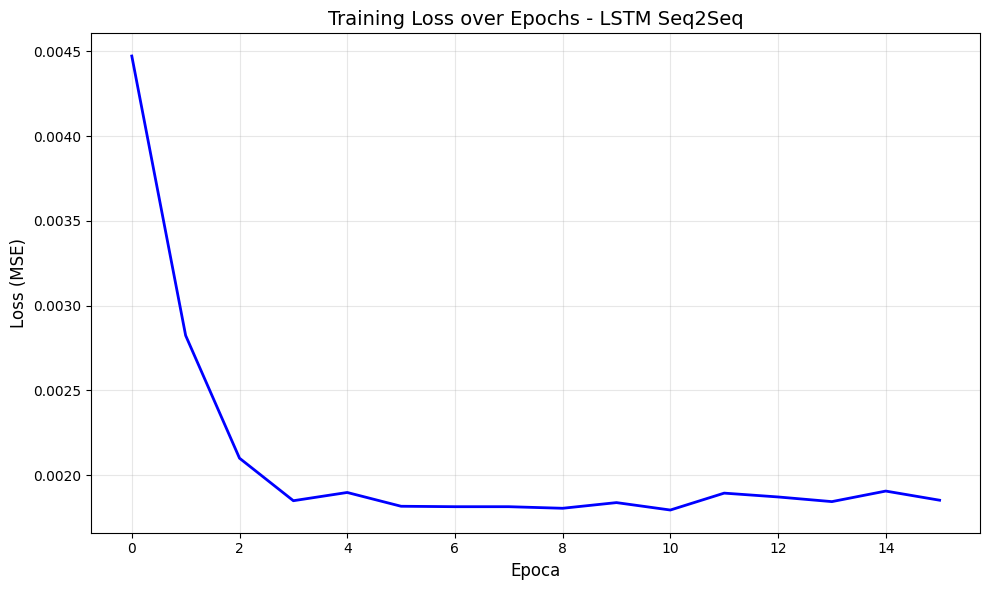

Loss iniziale: 0.004473
Loss finale: 0.001853


In [14]:
# Plot della loss durante il training
plt.figure(figsize=(10, 6))
plt.plot(train_losses, linewidth=2, color='blue')
plt.xlabel('Epoca', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss over Epochs - LSTM Seq2Seq', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Loss iniziale: {train_losses[0]:.6f}")
print(f"Loss finale: {train_losses[-1]:.6f}")

In [15]:
# Salva il modello
model_path = "seq2seq_lstm_energy_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
        'window_size': window_size
    },
    'train_losses': train_losses
}, model_path)
print(f"✓ Modello LSTM salvato: {model_path}")

✓ Modello LSTM salvato: seq2seq_lstm_energy_model.pth


## 9. INFERENCE & EVALUATION

In [16]:
# Test su una sequenza
model.eval()
with torch.no_grad():
    test_input = torch.FloatTensor(seq_building[0][['_value']].values).unsqueeze(0).to(device)
    test_target = torch.FloatTensor(seq_oven[0][['_value']].values).unsqueeze(0).to(device)
    
    # LSTM - no teacher forcing during inference
    predictions = model(test_input, target=None, teacher_forcing_ratio=0.0)
    predictions = predictions.cpu().numpy().squeeze()
    actual = test_target.cpu().numpy().squeeze()

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual, predictions)
mae = mean_absolute_error(actual, predictions)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")

Test MSE: 0.000514
Test MAE: 0.012046


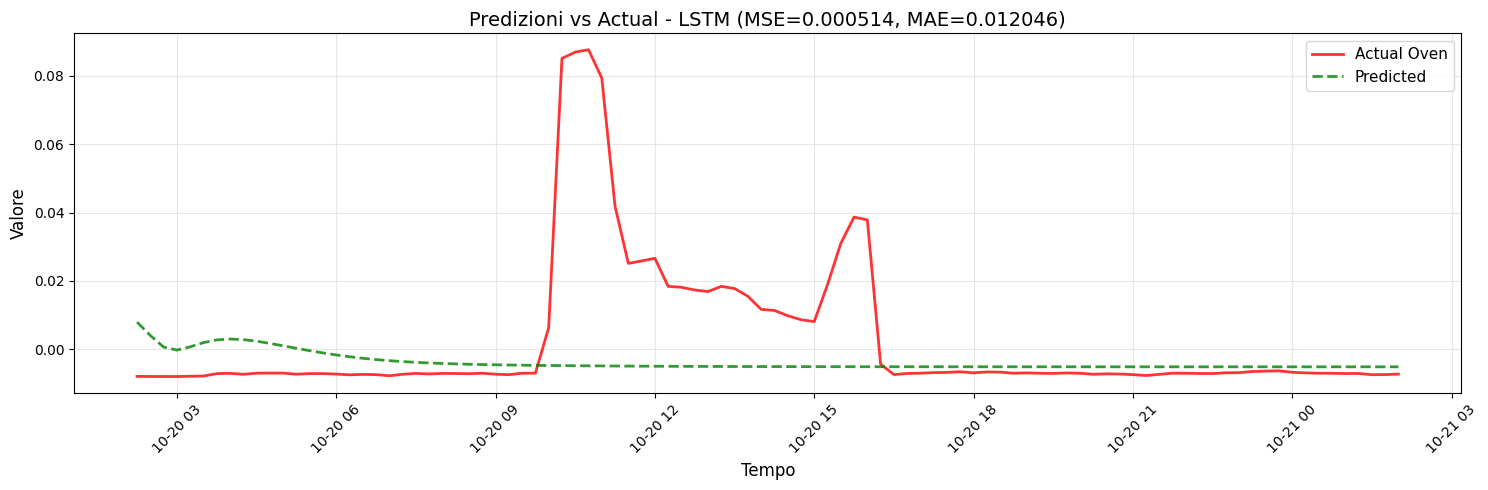

In [17]:
# Visualizza predizioni vs actual
plt.figure(figsize=(15, 5))
plt.plot(seq_oven[0]['_time'], actual, linewidth=2, label='Actual Oven', color='red', alpha=0.8)
plt.plot(seq_oven[0]['_time'], predictions, linewidth=2, label='Predicted', color='green', linestyle='--', alpha=0.8)
plt.xlabel('Tempo', fontsize=12)
plt.ylabel('Valore', fontsize=12)
plt.title(f'Predizioni vs Actual - LSTM (MSE={mse:.6f}, MAE={mae:.6f})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()